In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score

In [3]:
image_data_path = '/content/drive/MyDrive/PreciousMD/STAN_patches_segs/patches'
labels_csv_path = '/content/drive/MyDrive/PreciousMD/STAN_patches_segs/labels/STAN_labels.csv'


In [4]:
labels_df = pd.read_csv(labels_csv_path)
print(labels_df.head())  # Display the first few rows of the labels dataframe


        UID  MUT_STATUS
0  SUB_0367           1
1  SUB_0368           0
2  SUB_0369           0
3  SUB_0370           0
4  SUB_0371           0


In [5]:
# List of patient IDs
patient_ids = os.listdir(image_data_path)
print(f"Total patients: {len(patient_ids)}")

Total patients: 116


## Ensure all patients in image folders have corresponding labels in the CSV file

In [6]:
# Get patient IDs from image folders
patient_ids_from_folders = set(os.listdir(image_data_path))

# Get patient IDs from the CSV file
patient_ids_from_csv = set(labels_df['UID'])

# Find patients in folders but not in CSV
missing_in_csv = patient_ids_from_folders - patient_ids_from_csv
if missing_in_csv:
    print(f"Patients present in folders but missing in CSV: {missing_in_csv}")
else:
    print("All patients in folders have corresponding labels in the CSV file.")

# Find patients in CSV but not in folders
missing_in_folders = patient_ids_from_csv - patient_ids_from_folders
if missing_in_folders:
    print(f"Patients present in CSV but missing in folders: {missing_in_folders}")
else:
    print("All patients in the CSV file have corresponding folders.")


All patients in folders have corresponding labels in the CSV file.
Patients present in CSV but missing in folders: {'SUB_0380'}


In [7]:
# Check for duplicates in the CSV file
duplicate_patients_in_csv = labels_df[labels_df['UID'].duplicated()]['UID']
if not duplicate_patients_in_csv.empty:
    print(f"Duplicate patient IDs in CSV: {duplicate_patients_in_csv.to_list()}")
else:
    print("No duplicate patient IDs in the CSV file.")

# Check for duplicate folders (this is unlikely since operating systems usually don't allow duplicate folder names, but it's good to double-check)
if len(patient_ids_from_folders) != len(os.listdir(image_data_path)):
    print("There might be duplicate folders. Please check manually.")
else:
    print("No duplicate folders detected.")


No duplicate patient IDs in the CSV file.
No duplicate folders detected.


Given the results:

All patients in folders have corresponding labels in the CSV file:
This ensures that there won't be any "unlabeled" data issues when you proceed with training or validation. It means that every image you use will have an associated label.
Patients present in CSV but missing in folders: {'SUB_0380'}:
This indicates that while you have a label for patient SUB_0380, you do not have their image data. This discrepancy needs to be addressed before training.
Next Steps:

Address Missing Data: You need to decide how to address the missing image data for patient SUB_0380. Here are a few strategies:
a. Data Retrieval: If the missing data can be retrieved, locate the source of your dataset and check if the images for SUB_0380 were mistakenly excluded or misplaced.
b. Remove from CSV: If you can't retrieve the missing image data, it's best to remove the entry for SUB_0380 from the CSV file. This ensures consistency between your labels and data.

In [8]:
# Remove the SUB_0380 entry from the DataFrame
labels_df = labels_df[labels_df['UID'] != 'SUB_0380']


# Update the list of patient IDs to ensure it doesn't contain SUB_0380 and only includes IDs from the CSV that exist in the directory.
patient_ids = [pid for pid in os.listdir(image_data_path) if pid in labels_df['UID'].values]


0    93
1    23
Name: MUT_STATUS, dtype: int64
0    80.172414
1    19.827586
Name: MUT_STATUS, dtype: float64


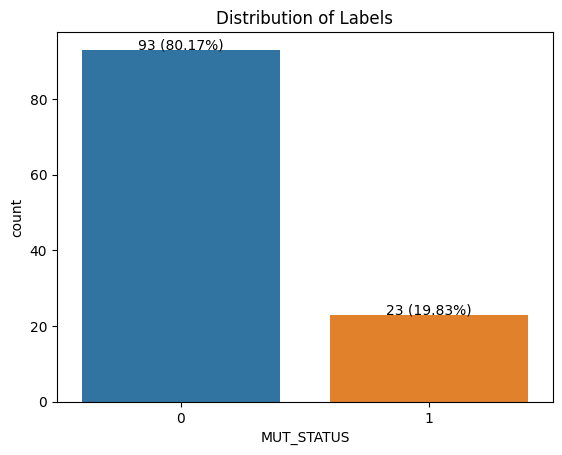

In [9]:
# Check the distribution of labels
label_distribution = labels_df['MUT_STATUS'].value_counts()
print(label_distribution)

# Get the distribution in percentages
label_distribution_percent = labels_df['MUT_STATUS'].value_counts(normalize=True) * 100
print(label_distribution_percent)

# Visualizing the distribution of labels along with counts
sns.countplot(x='MUT_STATUS', data=labels_df).set_title('Distribution of Labels')
for i, count in enumerate(label_distribution):
    plt.text(i, count, f'{count} ({label_distribution_percent.iloc[i]:.2f}%)', ha='center', va='baseline')
plt.show()

In [10]:
# Quick script to get unique image sizes across all patients
unique_image_sizes = set()
for patient_id in labels_df['UID']:
    patient_folder = os.path.join(image_data_path, patient_id)
    for img_name in os.listdir(patient_folder):
        img_path = os.path.join(patient_folder, img_name)
        img = Image.open(img_path)
        unique_image_sizes.add(img.size)
print(unique_image_sizes)


{(61, 61), (43, 43), (52, 52), (70, 70), (29, 29), (38, 38), (37, 37), (80, 80), (42, 42), (66, 66), (48, 48), (34, 34), (53, 53), (30, 30), (76, 76), (71, 71), (62, 62), (25, 25), (35, 35), (26, 26), (44, 44), (99, 99), (49, 49), (40, 40), (31, 31), (95, 95), (27, 27), (68, 68), (63, 63), (36, 36), (45, 45), (54, 54), (102, 102), (105, 105), (32, 32), (64, 64), (55, 55), (41, 41), (51, 51), (60, 60), (87, 87), (69, 69), (23, 23), (46, 46), (24, 24), (106, 106), (47, 47), (28, 28), (92, 92), (83, 83), (79, 79), (120, 120), (33, 33)}


# Creating PyTorch Dataset

In [11]:
# Defining a custom dataset for the tumor images
class TumorDataset(Dataset):

  # Initialisation method for the dataset
  def __init__(self, image_data_path, labels_df, num_patches_per_patient=5):
    self.image_data_path = image_data_path
    self.labels_df = labels_df
    self.num_patches_per_patient = num_patches_per_patient
    self.max_size = (64, 64)
    self.patient_ids = sorted([pid for pid in os.listdir(image_data_path) if pid in labels_df['UID'].values])
    self.file_paths = {pid: sorted(os.listdir(os.path.join(image_data_path, pid)))[:self.num_patches_per_patient] for pid in self.patient_ids}

    # Applying image transformations on the patches
    self.base_transform = transforms.Compose([
      transforms.Resize(self.max_size),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5], std=[0.5]),
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(degrees=10)
        ])


  def __len__(self):
    return len(self.patient_ids)

  # Method to fetch data for a specific index
  def __getitem__(self, idx):
        # Fetching patient ID for the given index
        pid = self.patient_ids[idx]

        # Loading image patches for the selected patient ID
        patches = [Image.open(os.path.join(self.image_data_path, pid, patch_path)) for patch_path in self.file_paths[pid]]

        # List to store transformed patches
        transformed_patches = []
        for patch in patches:
            # Calculating padding required to make the image of max_size
            pad_transform = transforms.Pad(
                (0, 0, self.max_size[0] - patch.size[1], self.max_size[1] - patch.size[0]), fill=0
            )

            # Applying the padding and other transformations to the image patch
            transform = transforms.Compose([pad_transform, self.base_transform])
            transformed_patches.append(transform(patch))

        # Combining all patches into a single tensor
        images = torch.stack(transformed_patches)

        # Fetching the label for the patient ID
        label_row = self.labels_df[self.labels_df['UID'] == pid]
        label = torch.tensor(label_row['MUT_STATUS'].values[0], dtype=torch.long)

        return images, label


In [12]:
dataset = TumorDataset(image_data_path, labels_df)
print(len(dataset))

116


In [13]:
# Looping through the first 5 entries of the dataset to inspect it
for i in range(5):
    images, label = dataset[i]
    print(f"Patient {i}:")
    print(f"Number of Patches: {images.shape[0]}")
    print(f"Image Shape: {images[0].shape}")
    print(f"Label: {label}\n")

Patient 0:
Number of Patches: 5
Image Shape: torch.Size([1, 64, 64])
Label: 1

Patient 1:
Number of Patches: 5
Image Shape: torch.Size([1, 64, 64])
Label: 0

Patient 2:
Number of Patches: 5
Image Shape: torch.Size([1, 64, 64])
Label: 0

Patient 3:
Number of Patches: 5
Image Shape: torch.Size([1, 64, 64])
Label: 0

Patient 4:
Number of Patches: 5
Image Shape: torch.Size([1, 64, 64])
Label: 0



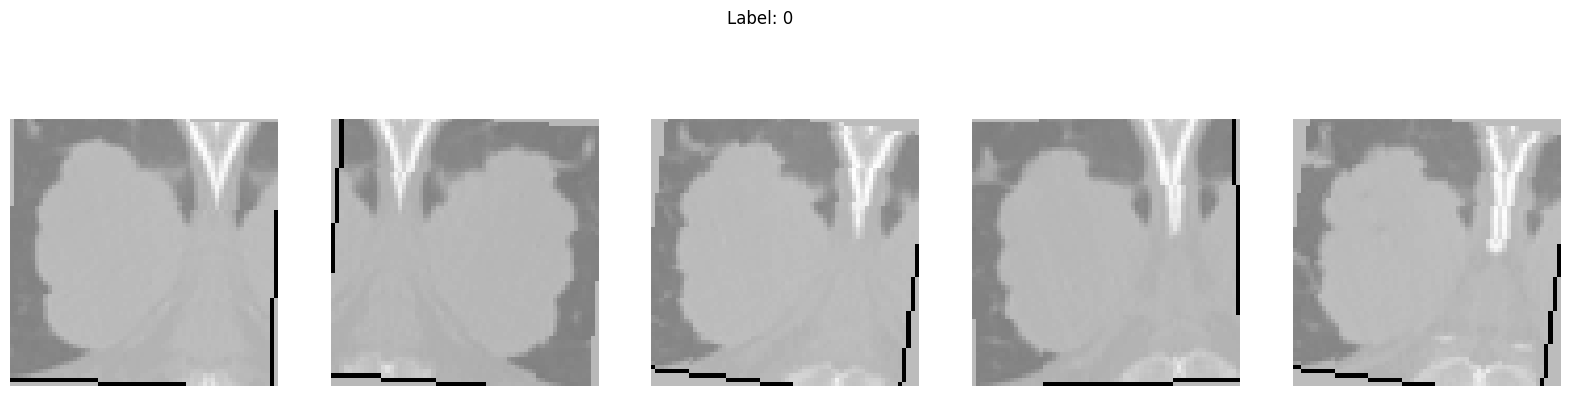

In [14]:
import matplotlib.pyplot as plt

def show_patches(patches, title=""):
    fig, axs = plt.subplots(1, len(patches), figsize=(20, 5))
    for i, patch in enumerate(patches):
        axs[i].imshow(patch[0], cmap='gray')  # Assuming single channel images
        axs[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Displaying patches for a patient
patches, label = dataset[10]
show_patches(patches, title=f"Label: {label}")


# Data Splitting

In [15]:
# Patient IDs and corresponding labels
X = patient_ids
y = labels_df['MUT_STATUS']

# Initial split parameters to segregate data into training and testing sets
n_splits = 1
test_size_initial = 0.2

# Stratified shuffle split for ensuring balanced classes in both train and test sets
sss_initial = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size_initial, random_state=42)

# Splitting the data into initial training and test sets
for train_index_initial, test_index in sss_initial.split(X, y):
    train_patient_ids_initial = [X[i] for i in train_index_initial]
    test_patient_ids = [X[i] for i in test_index]
    X_train_initial = labels_df[labels_df['UID'].isin(train_patient_ids_initial)]
    X_test = labels_df[labels_df['UID'].isin(test_patient_ids)]
    y_train_initial = X_train_initial['MUT_STATUS']
    y_test = X_test['MUT_STATUS']

# Parameters to further split the initial training data into final training and validation sets
n_splits = 1
validation_size = 0.1

# Stratified shuffle split for the second time to obtain validation data from the initial training set
sss_final = StratifiedShuffleSplit(n_splits=n_splits, test_size=validation_size, random_state=42)

# Splitting the initial training set into final training and validation sets
for train_index_final, validation_index in sss_final.split(X_train_initial, y_train_initial):
    train_patient_ids_final = [train_patient_ids_initial[i] for i in train_index_final]
    validation_patient_ids = [train_patient_ids_initial[i] for i in validation_index]
    X_train = labels_df[labels_df['UID'].isin(train_patient_ids_final)]
    X_val = labels_df[labels_df['UID'].isin(validation_patient_ids)]
    y_train = X_train['MUT_STATUS']
    y_val = X_val['MUT_STATUS']



In [16]:
# Checking class distribution
original_class_distribution = labels_df['MUT_STATUS'].value_counts(normalize=True)
train_class_distribution = y_train.value_counts(normalize=True)
val_class_distribution = y_val.value_counts(normalize=True)
test_class_distribution = y_test.value_counts(normalize=True)

print("Original Class Distribution:")
print(original_class_distribution)

print("Training Class Distribution:")
print(train_class_distribution)

print("Validation Class Distribution:")
print(val_class_distribution)

print("Test Class Distribution:")
print(test_class_distribution)

# Checking for patient overlap
train_patients = set(train_patient_ids_final)
val_patients = set(validation_patient_ids)
test_patients = set(test_patient_ids)

overlap_train_val = train_patients.intersection(val_patients)
overlap_train_test = train_patients.intersection(test_patients)
overlap_val_test = val_patients.intersection(test_patients)

if overlap_train_val or overlap_train_test or overlap_val_test:
    print("Data leakage detected. Patient overlap between sets.")
else:
    print("No data leakage. Sets are mutually exclusive.")

# Checking data shapes
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)


Original Class Distribution:
0    0.801724
1    0.198276
Name: MUT_STATUS, dtype: float64
Training Class Distribution:
0    0.804878
1    0.195122
Name: MUT_STATUS, dtype: float64
Validation Class Distribution:
0    0.8
1    0.2
Name: MUT_STATUS, dtype: float64
Test Class Distribution:
0    0.791667
1    0.208333
Name: MUT_STATUS, dtype: float64
No data leakage. Sets are mutually exclusive.
Training set shape: (82, 2)
Validation set shape: (10, 2)
Test set shape: (24, 2)


In [17]:
import torch.nn as nn
import torch.nn.functional as F

# Define a neural network for classifying individual patches
class PatchClassifier(nn.Module):
    def __init__(self):
        super(PatchClassifier, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(64*30*30, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # Sequence of convolutional layers followed by ReLU activation and pooling
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Flattening and passing through fully connected layers
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define a hierarchical classifier that aggregates predictions of multiple patches for a patient
class HierarchicalClassifier(nn.Module):
    def __init__(self, num_patches_per_patient=5):
        super(HierarchicalClassifier, self).__init__()

        # Number of patches per patient
        self.num_patches_per_patient = num_patches_per_patient

        # Instantiate the patch classifier
        self.patch_classifier = PatchClassifier()

    def forward(self, x):
        # Reshape input to process individual patches
        x = x.view(-1, 1, 64, 64)

        # Get predictions for each patch
        patch_predictions = self.patch_classifier(x)

        # Convert predictions to probabilities
        patch_probs = F.softmax(patch_predictions, dim=1)

        # Extract positive class probabilities
        positive_probs = patch_probs[:, 1]

        # Reshape to get probabilities for each patch of a patient
        positive_probs = positive_probs.view(-1, self.num_patches_per_patient)

        # Aggregate patch probabilities for a patient
        aggregated_prob = positive_probs.mean(dim=1)
        return aggregated_prob

# Instantiate the model and move it to GPU
model = HierarchicalClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


HierarchicalClassifier(
  (patch_classifier): PatchClassifier(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (dropout): Dropout(p=0.25, inplace=False)
    (fc1): Linear(in_features=57600, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [18]:
# Calculate the number of negative and positive samples in the training set
negative_samples = (y_train == 0).sum()
positive_samples = (y_train == 1).sum()
total_samples = len(y_train)

# Compute class weights for handling class imbalance
weight_for_0 = total_samples / (2.0 * negative_samples)
weight_for_1 = total_samples / (2.0 * positive_samples)

# Convert the class weights to a tensor and move it to GPU
weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float32)
weights = weights.to(device)

# Define the loss function using the computed class weights
criterion = nn.CrossEntropyLoss(weight=weights)

# Define the optimizer for training the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)



In [19]:
train_dataset = TumorDataset(image_data_path, X_train)
val_dataset = TumorDataset(image_data_path, X_val)
test_dataset = TumorDataset(image_data_path, X_test)

In [20]:
# Define the data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,      # Number of subprocesses to use for data loading
    pin_memory=True     # To speed up data transfer to the GPU
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10] - Training Loss: 0.7088, Training Accuracy: 0.3902, Training F1: 0.2424 - Validation Loss: 0.6986, Validation Accuracy: 0.8000, Validation F1: 0.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [2/10] - Training Loss: 0.6868, Training Accuracy: 0.8049, Training F1: 0.0000 - Validation Loss: 0.7106, Validation Accuracy: 0.8000, Validation F1: 0.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [3/10] - Training Loss: 0.7039, Training Accuracy: 0.8049, Training F1: 0.0000 - Validation Loss: 0.7077, Validation Accuracy: 0.8000, Validation F1: 0.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [4/10] - Training Loss: 0.6929, Training Accuracy: 0.8049, Training F1: 0.0000 - Validation Loss: 0.6909, Validation Accuracy: 0.8000, Validation F1: 0.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [5/10] - Training Loss: 0.6957, Training Accuracy: 0.7561, Training F1: 0.0000 - Validation Loss: 0.6988, Validation Accuracy: 0.8000, Validation F1: 0.0000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [6/10] - Training Loss: 0.6894, Training Accuracy: 0.6341, Training F1: 0.3182 - Validation Loss: 0.6956, Validation Accuracy: 0.4000, Validation F1: 0.2500


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [7/10] - Training Loss: 0.6856, Training Accuracy: 0.4634, Training F1: 0.2903 - Validation Loss: 0.6909, Validation Accuracy: 0.6000, Validation F1: 0.3333


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [8/10] - Training Loss: 0.6845, Training Accuracy: 0.5854, Training F1: 0.3704 - Validation Loss: 0.6896, Validation Accuracy: 0.4000, Validation F1: 0.2500


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [9/10] - Training Loss: 0.6765, Training Accuracy: 0.5976, Training F1: 0.4211 - Validation Loss: 0.6950, Validation Accuracy: 0.6000, Validation F1: 0.3333


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [10/10] - Training Loss: 0.6790, Training Accuracy: 0.6341, Training F1: 0.4000 - Validation Loss: 0.6951, Validation Accuracy: 0.9000, Validation F1: 0.6667


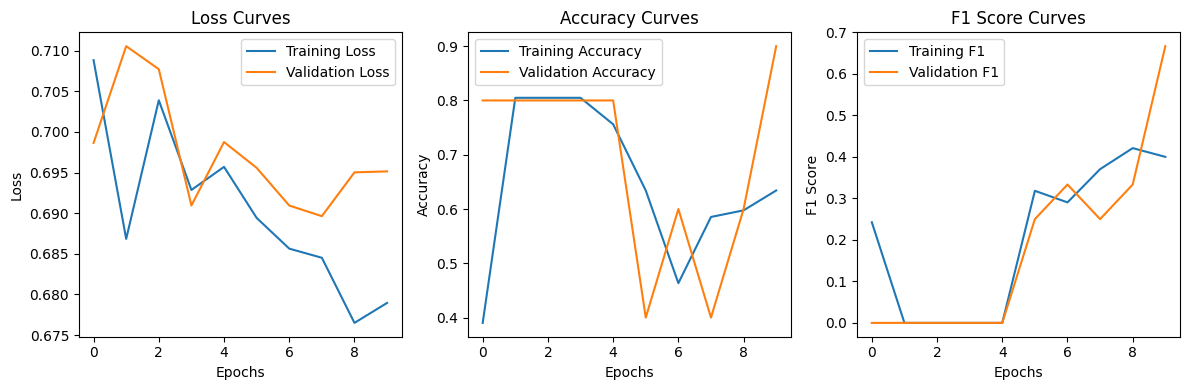

In [21]:

# Set random seed for reproducibility
torch.manual_seed(50)

# Hyperparameters and setup for training loop
num_epochs = 10
print_every = 1
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

# Lists to store training and validation metrics for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

for epoch in range(1, num_epochs + 1):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_train_labels = []
    all_train_preds = []

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward and backward passes
        optimizer.zero_grad()
        outputs = model(inputs)

        # Convert model's output to match the shape required for CrossEntropyLoss
        outputs_2d = outputs.unsqueeze(1)
        labels_2d = labels.view(-1, 1)
        combined_outputs = torch.cat((1 - outputs_2d, outputs_2d), dim=1)
        _, preds = torch.max(combined_outputs, 1)

        # Compute training statistics
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(preds.cpu().numpy())
        loss = criterion(combined_outputs, labels_2d.squeeze())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate metrics for training data
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    train_f1 = f1_score(all_train_labels, all_train_preds)
    train_f1_scores.append(train_f1)

    # Validation Phase
    model.eval()

    # Initialize variables to store validation metrics
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_labels = []
    all_val_preds = []

    # No gradient computations during validation for performance
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Convert the outputs to 2D for calculating loss
            outputs_2d = outputs.unsqueeze(1)
            labels_2d = labels.view(-1, 1)
            combined_outputs = torch.cat((1 - outputs_2d, outputs_2d), dim=1)

            # Get predicted class and accumulate correct predictions
            _, preds = torch.max(combined_outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(preds.cpu().numpy())

            loss = criterion(combined_outputs, labels_2d.squeeze())
            val_running_loss += loss.item()

    # Calculate average validation loss for the epoch
    val_epoch_loss = val_running_loss / len(val_loader)
    val_losses.append(val_epoch_loss)

    # Calculate validation accuracy and F1 score
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    val_f1 = f1_score(all_val_labels, all_val_preds)
    val_f1_scores.append(val_f1)

    if epoch % print_every == 0:
        print(f"Epoch [{epoch}/{num_epochs}] - Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Training F1: {train_f1:.4f} - Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1: {val_f1:.4f}")

    # Early stopping logic
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping! Best Validation Loss: {best_val_loss:.4f}")
            break

plt.figure(figsize=(12, 4))

# Plotting loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plotting accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

# Plotting F1 score
plt.subplot(1, 3, 3)
plt.plot(train_f1_scores, label='Training F1')
plt.plot(val_f1_scores, label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score Curves')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
# Model evaluation
model.eval()

test_running_loss = 0.0
correct_test = 0
total_test = 0
all_test_labels = []
all_test_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        # Adjust for binary classification
        outputs_2d = outputs.unsqueeze(1)
        labels_2d = labels.view(-1, 1)
        combined_outputs = torch.cat((1 - outputs_2d, outputs_2d), dim=1)

        _, preds = torch.max(combined_outputs, 1)
        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(preds.cpu().numpy())

        loss = criterion(combined_outputs, labels_2d.squeeze())
        test_running_loss += loss.item()

test_epoch_loss = test_running_loss / len(test_loader)
test_accuracy = correct_test / total_test
test_f1 = f1_score(all_test_labels, all_test_preds)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
print(f"Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")

Test Loss: 0.6759, Test Accuracy: 0.7917, Test F1 Score: 0.2857
